# Plant disease detection system

## For this project, we used data from kaggle on plantVillage dataset and sklearn library for our model training. Use your path to data directory also taking into account the how many categories that you have in your directory.

In [1]:
import os
import cv2
labels_list=[]
valid_images_to_continue_with = []
invalid_images=0
categories_name=[0,0,0,0,0]
def check_valid_images(directory, target_folders):
    i=-1
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)

        if os.path.isdir(folder_path) and folder in target_folders:
            i=i+1
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)

                try:
                    # Try to load the image
                    img = cv2.imread(file_path)
                    if img is None:
                        invalid_images=invalid_images+1

                    else:
                        valid_images_to_continue_with.append(img)
                        categories_name[i]=categories_name[i]+1
                        labels_list.append(folder)

                except Exception as e:
                    invalid_images=invalid_images+1


# Specify the target folders
target_folders = [
                  'Potato___Early_blight',
                  'Potato___Late_blight',
                  'Tomato__healthy'
                 ]

# Replace '/kaggle/input/plantdisease/' with the path to your image directory
check_valid_images('data/', target_folders)
print('The number of valid images to use: ', len(valid_images_to_continue_with))
print('the number of invalid images are : ',invalid_images)
print('number of each category is : ',categories_name)

The number of valid images to use:  1988
the number of invalid images are :  0
number of each category is :  [988, 1000, 0, 0, 0]


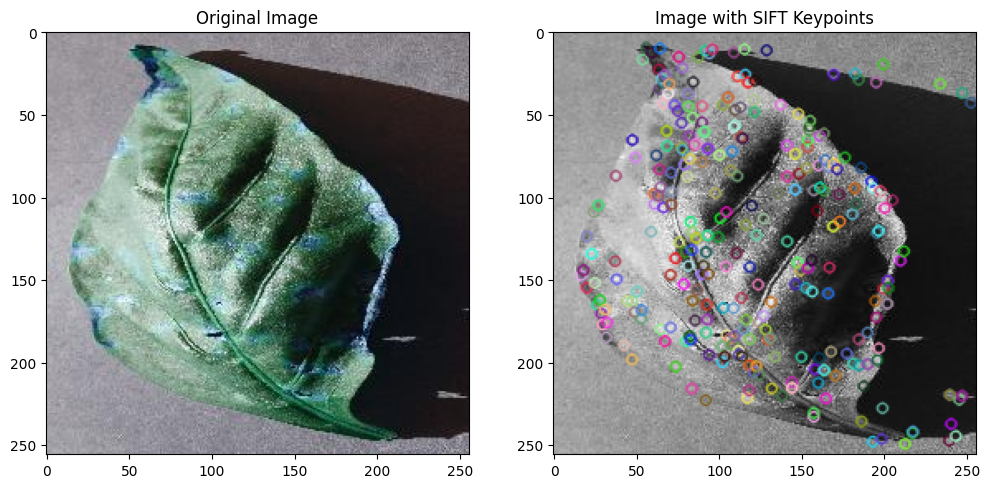

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

# Assuming valid_images_to_continue_with is a list of images
# If not, you can modify the code accordingly

# Choose an image from your dataset
image = valid_images_to_continue_with[1]

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# current_filtered = scipy.ndimage.median_filter(gray_image, size=3)

# Create SIFT object
sift = cv2.SIFT_create()

# Detect SIFT keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(gray_image, None)

# Visualize SIFT keypoints on the image
image_with_keypoints = cv2.drawKeypoints(gray_image, keypoints, None)

# Display the original image and the one with keypoints
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(image,), plt.title('Original Image')
plt.subplot(122), plt.imshow(image_with_keypoints), plt.title('Image with SIFT Keypoints')
plt.show()


In [3]:
keypoints_list=[]
descriptors_list=[]

for i in range(len(valid_images_to_continue_with)):
    image = valid_images_to_continue_with[i]
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     edges_original_img=cv2.Canny(image, 50, 150)

    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)
    

In [4]:
import os              
from PIL import Image   #python image liberary 
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import random


In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Assuming descriptors_list is a list of descriptors
# Filter out None values
filtered_descriptors = [desc for desc in descriptors_list if desc is not None]

# Pad descriptors to a fixed length (e.g., 500)
max_length = 500
padded_descriptors = pad_sequences(filtered_descriptors, maxlen=max_length, padding='post', truncating='post', dtype='float32')

# Flatten the 3D array to a 2D array
flattened_descriptors = padded_descriptors.reshape((len(padded_descriptors), -1))

# Convert the list of flattened descriptors to a numpy array
X = np.array(flattened_descriptors)


# Converting strings in ***lapels_list*** to their crossponding integers

In [6]:
from sklearn.metrics import adjusted_rand_score

# Create a mapping from string labels to integers
label_mapping = {label: i for i, label in enumerate(set(labels_list))}

# Convert y_train to integers using the mapping
labels_list_int = [label_mapping[label] for label in labels_list]

print(label_mapping)

{'Pepper__bell___Bacterial_spot': 0, 'Potato___Early_blight': 1, 'Potato___Late_blight': 2}


# **Main Alg** (scalling + dimentionality reducion + kmeans)

In [7]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(
    X, labels_list_int, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction (PCA)
pca = PCA(n_components=64)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

# Number of clusters
K = 3

# Creating the model
kmeans_model = KMeans(n_clusters=K, random_state=42, max_iter=1000)

# Training the model
kmeans_model.fit(X_train_reduced)

# Pridictions
y_pred_train = kmeans_model.labels_
y_pred_test = kmeans_model.predict(X_test_reduced)



/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# **Confusion Matrix**

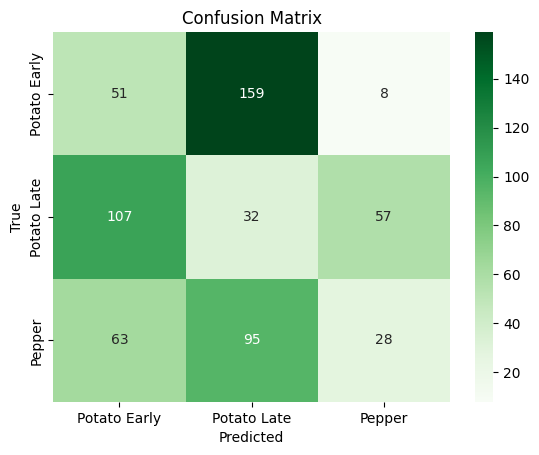

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=['Potato Early', 'Potato Late', 'Pepper'], yticklabels=['Potato Early', 'Potato Late', 'Pepper'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Accuracy Score**

In [9]:
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_test))

Accuracy Score:
0.185


# **ROC Curve**

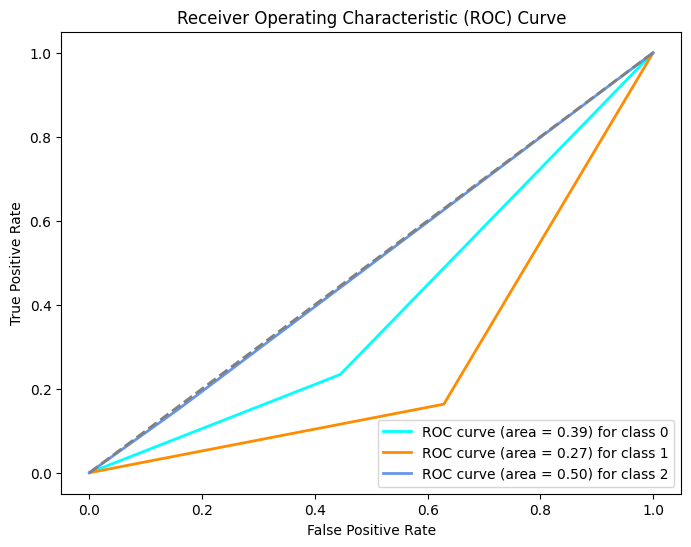

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle


# Binarize the output
n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_test_bin = label_binarize(y_pred_test, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_test_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_test_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
lw = 2

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')


# Plot chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

# Set labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()


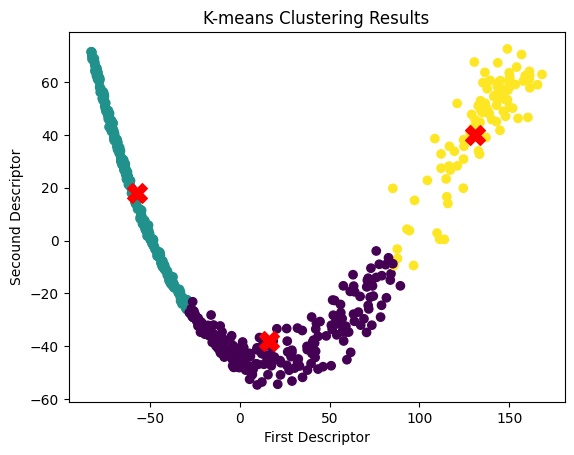

Cluster Assignments: [0 1 0 2 1 1 1 1 1 0 0 0 0 2 2 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 2 1 0 2 2 1
 1 2 1 1 0 1 0 0 1 1 1 0 1 0 2 0 1 2 2 1 1 0 2 2 1 2 1 1 0 2 0 0 1 1 1 2 0
 0 1 2 1 0 0 0 1 1 2 0 0 1 1 1 0 1 1 1 2 1 2 2 1 1 1 0 1 0 1 1 0 1 2 2 0 2
 1 1 0 0 0 0 0 2 1 1 0 0 0 2 1 0 2 0 0 1 0 0 2 2 1 1 0 0 0 1 1 0 2 1 1 0 0
 0 1 0 1 0 2 1 0 2 2 0 1 1 1 2 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 2 1
 0 1 2 1 1 2 1 1 1 2 1 0 2 0 1 0 0 1 1 1 0 1 0 1 2 0 0 1 1 1 0 1 1 2 0 0 0
 0 1 1 0 2 0 0 0 0 0 0 0 1 0 1 2 0 1 0 2 1 0 0 1 1 1 0 0 1 0 1 2 0 1 0 0 1
 1 0 0 1 1 0 1 2 0 0 0 2 0 1 0 2 1 0 2 0 0 1 2 0 1 0 2 0 0 1 0 1 0 1 2 2 1
 2 0 2 1 0 1 1 2 0 2 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 2 0 1 0 2 0 0 1 0 1 1
 2 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 2 1 2 0 2 1 2 0 2 1 0 1 0 0 0
 1 1 2 1 2 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 2 1 2 0 0 0 1 1 0 1 1 0 0 2 1 0 0
 2 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0
 1 0 1 1 2 0 1 0 1 1 2 1 1 2 1 0 1 0 0 1 1 0 1 0 0 1 2 0 2 2 0 1 0 0 0 2 2
 2 0

In [11]:
# Visualize the results
plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_pred_test, cmap='viridis')
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.title('K-means Clustering Results')
plt.xlabel('First Descriptor')
plt.ylabel('Secound Descriptor')
plt.show()


print("Cluster Assignments:", y_pred_test)